<a href="https://colab.research.google.com/github/rroszczyk/1DI2243/blob/main/balans_bieli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys
import os
%matplotlib inline

import requests

def pobierzPlik(url, nazwaPliku):
    req = requests.get(url, stream=True)
    with open(nazwaPliku, 'wb') as uchwytPliku:
        for chunk in req.iter_content():
            uchwytPliku.write(chunk)

nazwyPlikow = ['794.tif', '795.tif', '801.tif', '802.tif', '804.tif', '808.tif']
for nazwa in nazwyPlikow:
  pobierzPlik("https://github.com/rroszczyk/1DI2243/raw/main/L2/"+nazwa, nazwa)


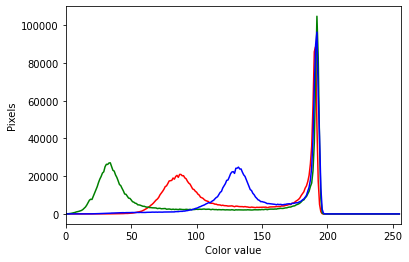

In [2]:
img = cv2.imread('794.tif')
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)

plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        img[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

In [3]:
def gray_world(nimg):
    nimg = nimg.transpose(2, 0, 1).astype(np.uint32)
    mu_g = np.average(nimg[1])
    nimg[0] = np.minimum(nimg[0] * (mu_g/np.average(nimg[0])),255)
    nimg[2] = np.minimum(nimg[2] * (mu_g/np.average(nimg[2])),255)
    return  nimg.transpose(1, 2, 0).astype(np.uint8)

def max_white(nimg):
    if nimg.dtype==np.uint8:
        brightest=float(2**8)
    elif nimg.dtype==np.uint16:
        brightest=float(2**16)
    elif nimg.dtype==np.uint32:
        brightest=float(2**32)
    else:
        brightest==float(2**8)
    nimg = nimg.transpose(2, 0, 1)
    nimg = nimg.astype(np.int32)
    nimg[0] = np.minimum(nimg[0] * (brightest/float(nimg[0].max())),255)
    nimg[1] = np.minimum(nimg[1] * (brightest/float(nimg[1].max())),255)
    nimg[2] = np.minimum(nimg[2] * (brightest/float(nimg[2].max())),255)
    return nimg.transpose(1, 2, 0).astype(np.uint8)

def retinex(nimg):
    nimg = nimg.transpose(2, 0, 1).astype(np.uint32)
    mu_g = nimg[1].max()
    nimg[0] = np.minimum(nimg[0]*(mu_g/float(nimg[0].max())),255)
    nimg[2] = np.minimum(nimg[2]*(mu_g/float(nimg[2].max())),255)
    return nimg.transpose(1, 2, 0).astype(np.uint8)

def retinex_with_adjust(nimg):
    """
    from 'Combining Gray World and Retinex Theory for Automatic White Balance in Digital Photography'
    """
    nimg = nimg.transpose(2, 0, 1).astype(np.uint32)
    sum_r = np.sum(nimg[0])
    sum_r2 = np.sum(nimg[0]**2)
    max_r = nimg[0].max()
    max_r2 = max_r**2
    sum_g = np.sum(nimg[1])
    max_g = nimg[1].max()
    coefficient = np.linalg.solve(np.array([[sum_r2,sum_r],[max_r2,max_r]]),
                                  np.array([sum_g,max_g]))
    nimg[0] = np.minimum((nimg[0]**2)*coefficient[0] + nimg[0]*coefficient[1],255)
    sum_b = np.sum(nimg[1])
    sum_b2 = np.sum(nimg[1]**2)
    max_b = nimg[1].max()
    max_b2 = max_r**2
    coefficient = np.linalg.solve(np.array([[sum_b2,sum_b],[max_b2,max_b]]),
                                             np.array([sum_g,max_g]))
    nimg[1] = np.minimum((nimg[1]**2)*coefficient[0] + nimg[1]*coefficient[1],255)
    return nimg.transpose(1, 2, 0).astype(np.uint8)

def norm(img, perc = 0.05):
    for channel in range(img.shape[2]):
        mi, ma = (np.percentile(img[:,:,channel], perc), np.percentile(img[:,:,channel],100.0-perc))
        img[:,:,channel] = np.uint8(np.clip((img[:,:,channel]-mi)*255.0/(ma-mi), 0, 255))
    return img

In [4]:
def compare(file_name):
  img = cv2.imread(file_name)
  color = ('b','g','r')

  fig, ax = plt.subplots(2, 3, figsize=(24, 12))

  ax[0, 0] = plt.subplot(2, 3, 1)
  ax[0, 1] = plt.subplot(2, 3, 2)
  ax[0, 2] = plt.subplot(2, 3, 3)
  ax[1, 0] = plt.subplot(2, 3, 4)
  ax[1, 1] = plt.subplot(2, 3, 5)
  ax[1, 2] = plt.subplot(2, 3, 6)

  ax[0, 0].imshow(cv2.imread('794.tif'))
  ax[0, 0].set_title('Obraz referencyjny')
  ax[0, 0].axis('off')

  ax[0, 1].imshow(img)
  ax[0, 1].set_title('Obraz oryginalny')
  ax[0, 1].axis('off')

  ax[0, 2].imshow(max_white(img))
  ax[0, 2].set_title('Max White')
  ax[0, 2].axis('off')

  ax[1, 0].imshow(gray_world(img))
  ax[1, 0].set_title('Gray World')
  ax[1, 0].axis('off')

  ax[1, 1].imshow(norm(gray_world(img), 0.05))
  ax[1, 1].set_title('Normalizowany Gray World')
  ax[1, 1].axis('off')

  ax[1, 2].imshow(retinex_with_adjust(img))
  ax[1, 2].set_title('Retinex With Adjust')
  ax[1, 2].axis('off')

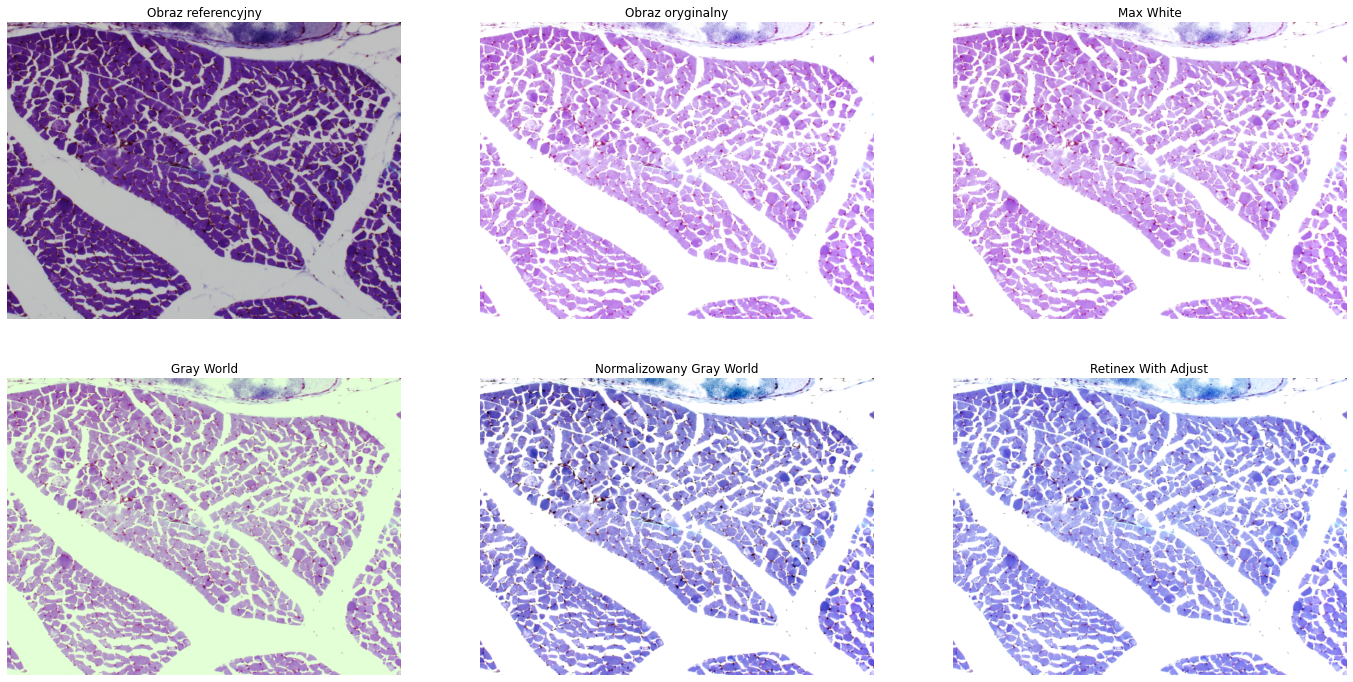

In [5]:
compare('795.tif')

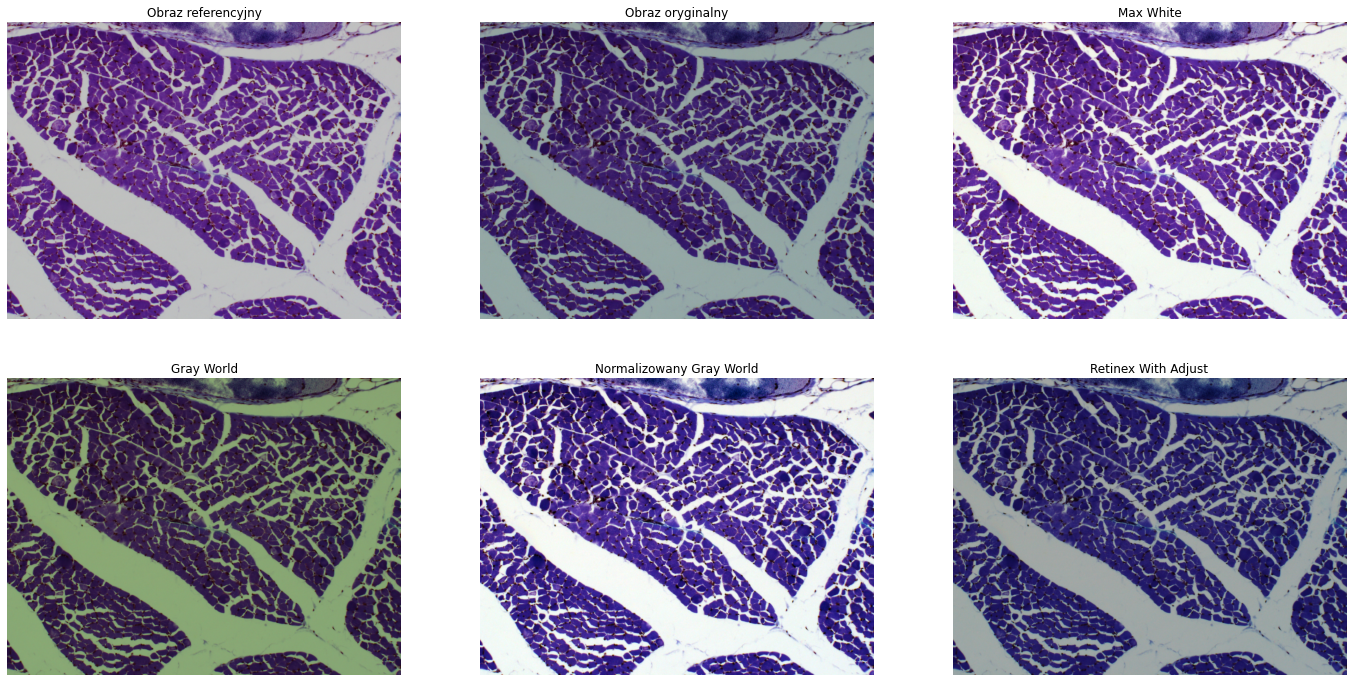

In [6]:
compare('801.tif')

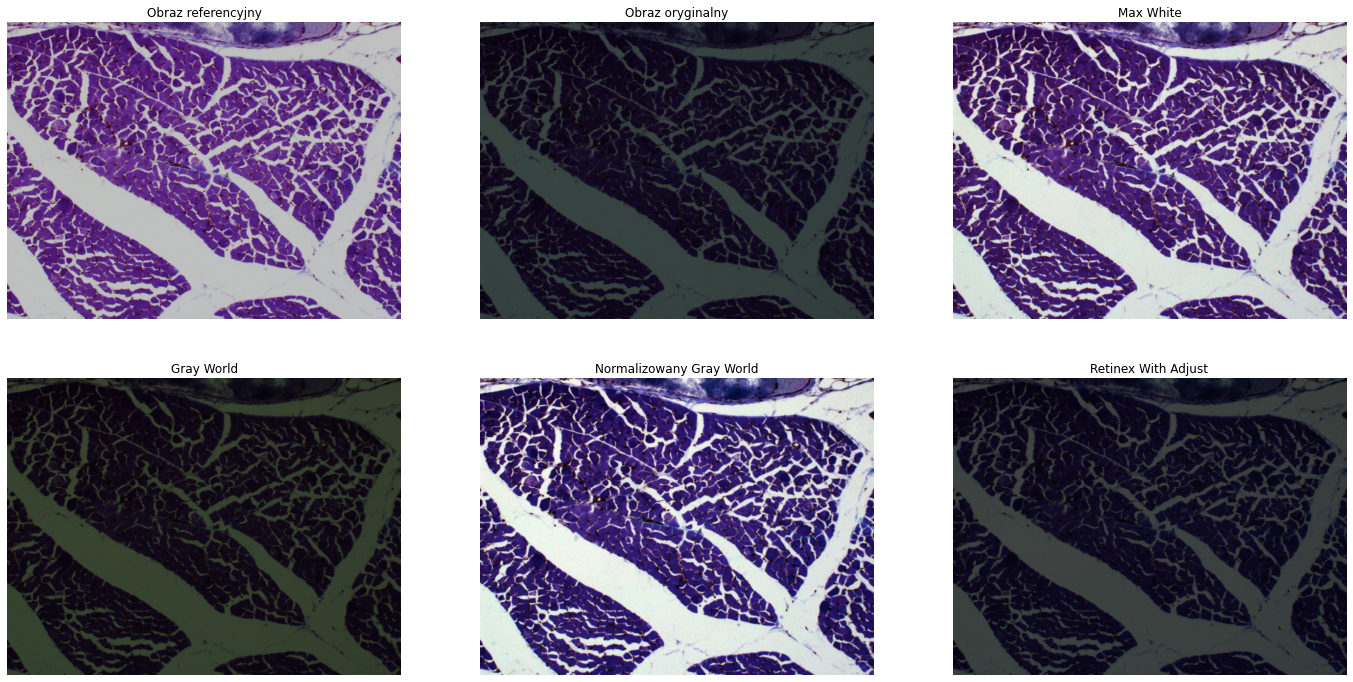

In [7]:
compare('802.tif')

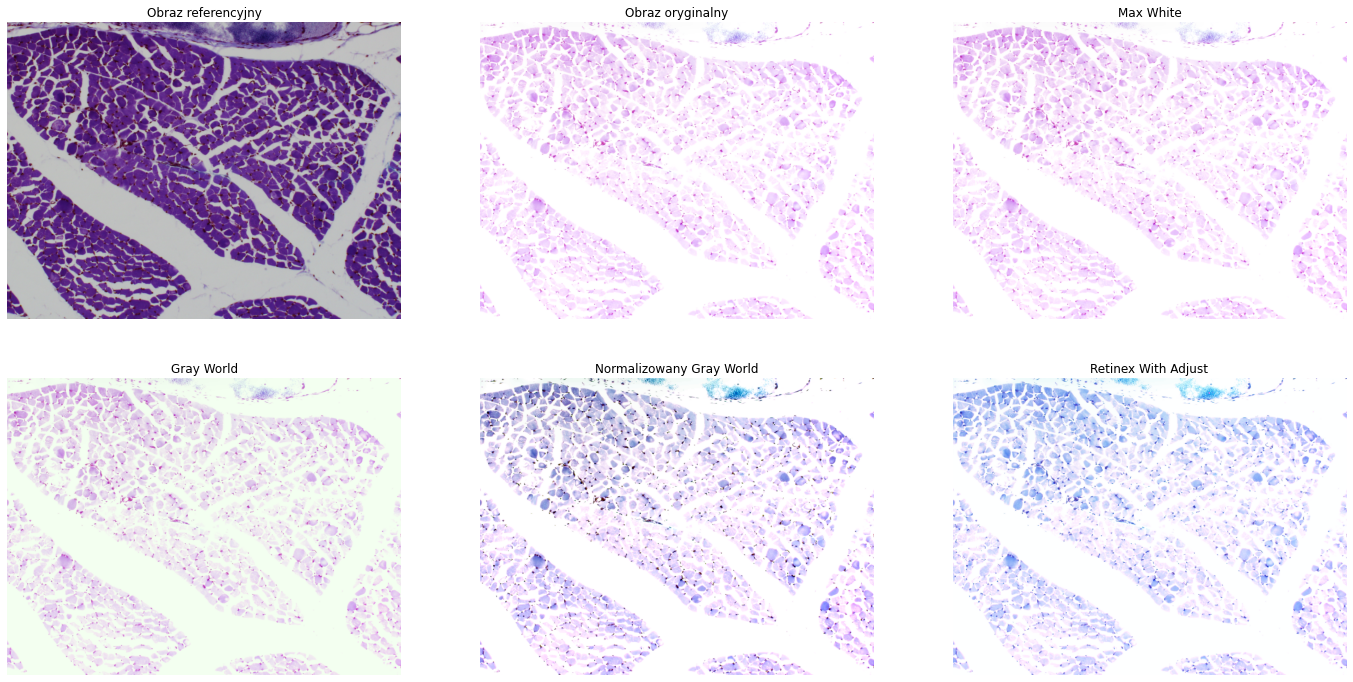

In [8]:
compare('804.tif')

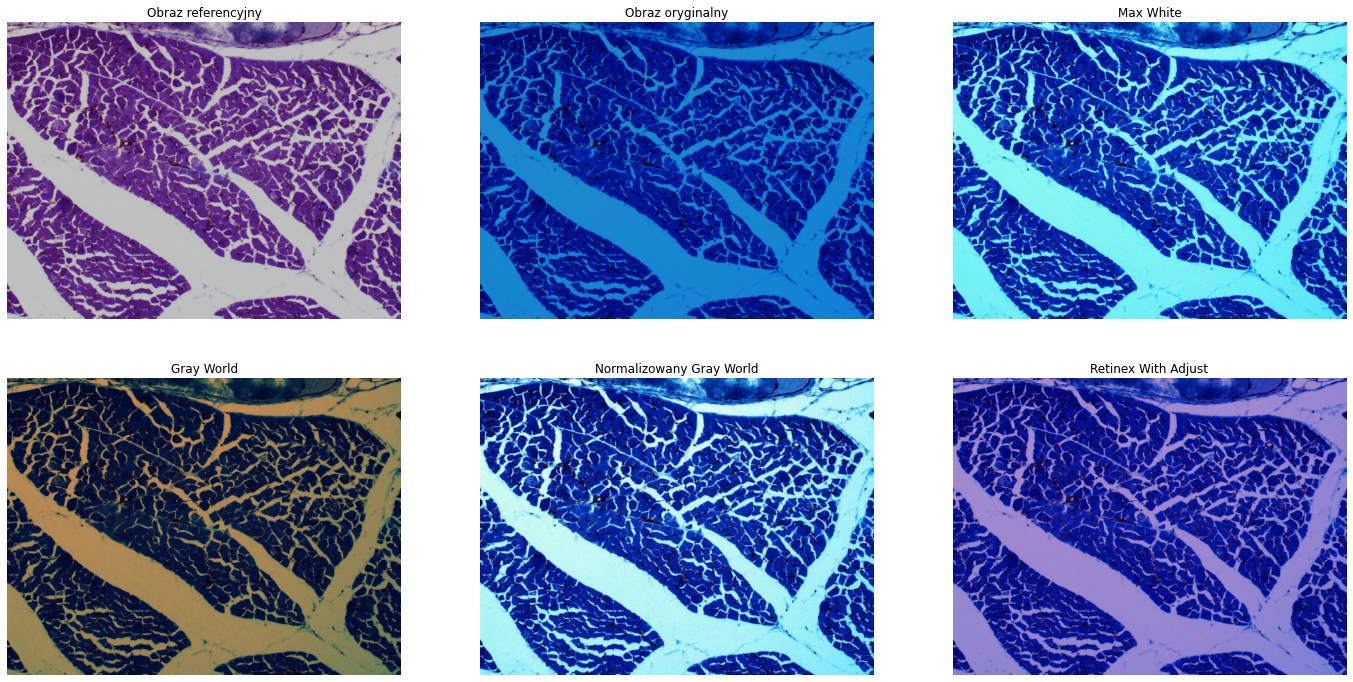

In [9]:
compare('808.tif')